<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/TrDesign_GD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TrDesign**
For details see following link: https://github.com/gjoni/trDesign

download mystery code

In [1]:
%%bash
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/models.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/utils.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/6MRR.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/to_pdb.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/bkgr_models.zip
unzip -qqo models.zip
unzip -qqo bkgr_models.zip
pip -q install py3Dmol

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
import py3Dmol

from utils import *
from models import *
from to_pdb import *

In [3]:
#@title **Plot Functions** (run this cell)
def plot_feat(x):
  '''plot each feature'''
  plt.figure(figsize=(4*4,4))
  for n,(k,v) in enumerate(split_feat(x).items()):
    plt.subplot(1,4,n+1); plt.title(k)
    plt.imshow(np.squeeze(v).argmax(-1),cmap="binary")
  plt.show()

def animate(design, do_ic=False):
  '''animate given trajectory'''
  fig, imgs = plt.figure(figsize=(6,3), dpi=100),[]
  gs = GridSpec(1,4, figure=fig)
  if do_ic:
    ax1 = fig.add_subplot(gs[0,0:2])
    ax1.axis(False)
    ax1.title.set_text("distance matrix")
    ax2 = fig.add_subplot(gs[0,2:4])
    ax2.axis(False)
    ax2.title.set_text("coevolution matrix")
  else:
    ax1 = fig.add_subplot(gs[0,0:2])
    ax1.axis(False);ax1.title.set_text("distance matrix")
    ax2 = fig.add_subplot(gs[0,2])
    ax2.axis(False);ax2.title.set_text("sequence")
    ax3 = fig.add_subplot(gs[0,3])
    ax3.axis(False);ax3.title.set_text("gradient")

  # go through each step along traj
  for k,out in enumerate(design["traj"]):
    # plot distance (contact map)
    pred = split_feat(out["feat"])["dist"][0].argmax(-1)
    # plot pssm (probability of amino acid at each position)
    im1 = ax1.imshow(pred, animated=True,cmap="binary")
    if do_ic:
      ic = inv_cov(out["pssm"][0].argmax(-1))
      im2 = ax2.imshow(ic, animated=True,cmap="binary")
      imgs.append([im1,im2])
    else:
      pssm = out["pssm"][0,0]
      im2 = ax2.imshow(pssm, animated=True,vmin=0,vmax=1,cmap="binary")
      grad = out["grad"][0,0]
      im3 = ax3.imshow(grad, animated=True,vmin=-0.1,vmax=0.1,cmap="bwr")
      imgs.append([im1,im2,im3])
  ani = animation.ArtistAnimation(fig, imgs, blit=True, interval=40)
  plt.close()
  return ani.to_html5_video()

def get_pdb(design, pdb_filename="out.pdb"):
  '''given features, return approx. 3D structure'''
  if "I" in design: seq = design["I"]
  if "pssm" in design: seq = design["pssm"]
  seq = N_to_AA(np.squeeze(seq).argmax(-1))[0]
  xyz, dm = feat_to_xyz(np.squeeze(design["feat"]))
  save_PDB(pdb_filename, xyz, dm, seq)

  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

#**PART 1** - Fixed backbone design!
For Part 2, we'll using TrDesign NN to design a new sequence for a given protein backbone!

![the protocol](https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/notebooks/figure_1.png)

step 1: load features from protein structure (PDB)

In [4]:
pdb = prep_input("6MRR.pdb", chain="A")
_feat = pdb["feat"]
_seq = np.eye(20)[AA_to_N(pdb["seq"])]

instead of using a background distribution of features (as in part 1), we will instead try to design a sequence that matches existing features extracted from a known 3D protein structure (PDB)

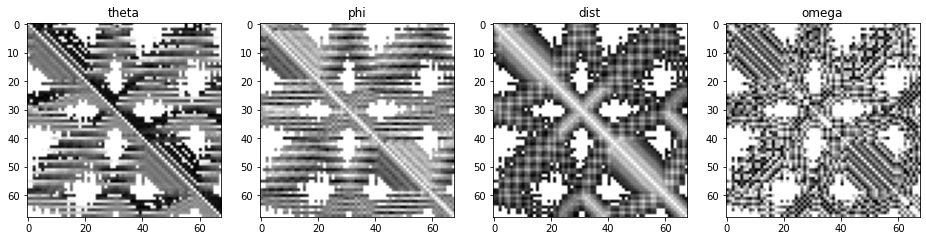

In [5]:
# these are the "Target"
plot_feat(_feat)

What are these "features"?
These are the 6D transformation for every pair of residues that describe a protein structure.
Using this representation of a protein, one could theorically reconstruct the 3D structure exactly.

![6D transformation](https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/notebooks/6D.png)

step 2: initialize the design model

In [6]:
# WARNING, for demo we use n_models=1, in practice you should ALWAYS use n_models=5
model = mk_design_model(add_pdb=True, n_models=1)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


step 3: design a new sequence (aka. optimize sequence to match target features derived from the PDB file)

In [7]:
design = model.design(inputs={"pdb":_feat[None]}, return_traj=True)

10 loss:{'pdb':2.621438}
20 loss:{'pdb':2.3836567}
30 loss:{'pdb':1.7340795}
40 loss:{'pdb':1.5916226}
50 loss:{'pdb':1.3948137}
60 loss:{'pdb':1.3200737}
70 loss:{'pdb':1.2869905}
80 loss:{'pdb':1.3171651}
90 loss:{'pdb':1.257457}
100 loss:{'pdb':1.257625}
FINAL loss:{'pdb':1.2472322}


step 4: analyze

In [8]:
# the reported loss it the CCE (categorical cross entropy)
# between the predicted features and target features
# loss = -target * log(pred)
-0.25 * (_feat * np.log(design["feat"])).sum(-1).mean()

1.2472322267449691

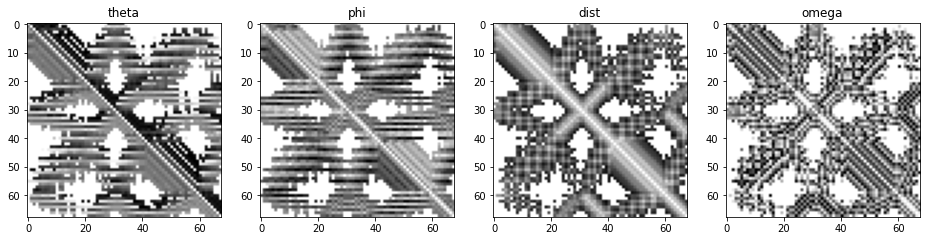

In [9]:
plot_feat(design["feat"])

the designed sequence

In [10]:
N_to_AA(design["I"].argmax(-1))

['KDPPKWQPFMQKLKEKWEKTGAPNFEMTYNGGRVTITFKKVPDEFMDLLTELQKEHAREGIPIQINVE']

movie time

In [11]:
HTML(animate(design))

**But.. but, how do I see my protein... in 3D?**
Normally we'd input the predicted constraints (or features) into PyRosetta for structure prediction... but since this is quite expensive to run in Google Colab, for demo purposes let's use a quick approximation (secret recipe) that converts the pairwise 6D features into a full 3D structure!

In [12]:
get_pdb(design,"6MRR_redesign.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#**PART 2** - MSA design!
For Part 3, we'll design new protein family (or MSA or library of sequences) for a given protein backbone!

![msa_design](https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/notebooks/msa_design_lowres.png)

Note, we are reusing the PDB features from Part 2. If you skipped ahead, you'll need to extract PDB features first.

step 1: initialize the design model for MSA design

In [13]:
# note, since the model has more free parameters, and we know that it can easily design a single
# sequence to match this backbone, we introduce a dropout during training to push the model 
# to optimize all input parameters
model = mk_design_model(add_pdb=True, msa_design=True, n_models=1, feat_drop=0.8)

mode: msa design
loading model: xaa
The loss function is composed of the following: ['pdb']


step 2: design 1K (you can increase) sequences to match backbone

In [14]:
# we'll design 1K sequences!
design = model.design(inputs={"pdb":_feat[None]}, num=1000, return_traj=True)

10 loss:{'pdb':2.67769}
20 loss:{'pdb':2.3120813}
30 loss:{'pdb':1.7073587}
40 loss:{'pdb':2.1427522}
50 loss:{'pdb':1.7930859}
60 loss:{'pdb':1.600417}
70 loss:{'pdb':1.5683111}
80 loss:{'pdb':1.4285262}
90 loss:{'pdb':1.5324239}
100 loss:{'pdb':1.4734967}
FINAL loss:{'pdb':1.319636}


step 3: analyze!

In [15]:
N_to_AA(design["I"].argmax(-1)[:10])

['KKNPNFQEIIKEVRKKYRDNGFPECEWKYSNGYWTVTCKKVPEDQVRNMMQWYRRHQEQGMPMEMWPD',
 'KKDPDFQEDWKKVRKKCEKNGGPKPKVRQDPNYVWATVDENSEDQAANMAQLYRFHQAKGVPMFIQTD',
 'KKDPNFQRFWPKFRKIYQDNGFKDMVIKQGPNYVWATCKKNGPDQKRLLMQMYKECQSFGKPMEMGPD',
 'KKNPNYQEIYKEFRKKLRENGGKEEKCKKTGGYWTLKVKKNPEDMARNLMQLYRRCQDQGMPMFMWPD',
 'KKNENYQNWWKEFRKKYRENGGPKMKIYQGGNYACLKFPKNPEEMFKNLMQMYRICQDQGIPMEMWPD',
 'KKDKRFQKDWKKVRKKCRDNGMEKFKIKQDDNYVWLKVKENSPPAPRNMMQLYKFHQDKGEPMRMQPD',
 'KKNPNYQNIRKEMRDKCEVNDGPEVEIDEGGGYFTVKVKKNPPPQPRNLMQMYRQHQEQGMPMFPQPD',
 'KKMPNFQEFWKLFEKRYRKNGFEKCVLYQDGNYVTVTFPKNPPDQARYLASMYRRLGDMGKPPFPQPD',
 'KKNPRYQHVKKKIRKTCQKNGGKKVKYYKPGDYVWCKVPKNPPDQARAWAQLYKEIHDQGYPIRIWWD',
 'KKDKNFQEDKKLCRKRCRKTGGPKPTWKKGDNRVIMKCRENPPDLARYMASMYRFLKDKGYPMEIGWD']

In [16]:
# note, instead of plotting single sequence on the right now we plot
# the inverse covariance of the MSA (multiple sequence alignment)
HTML(animate(design,do_ic=True))

#**PART 3** - hallucination time!
For Part 1, we'll using TrDesign NN to "hallucinate" or design a new (or denovo) protein (both sequence and structure), that doesn't exist in nature.

step 1: compute a background distribution, that describes what a protein structure looks like, for given length.

In [17]:
length = 50 # feel free to change to see what happens!
_bkg = get_bkg([length])[length]

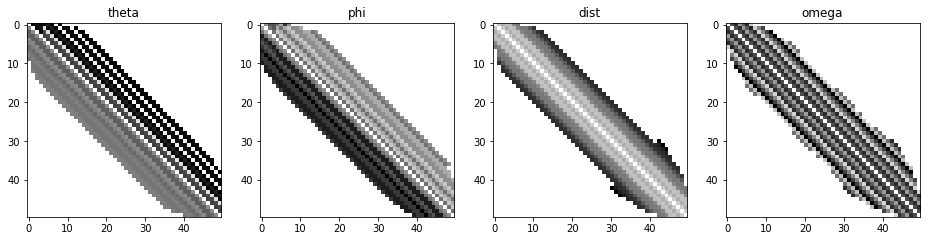

In [18]:
plot_feat(_bkg)

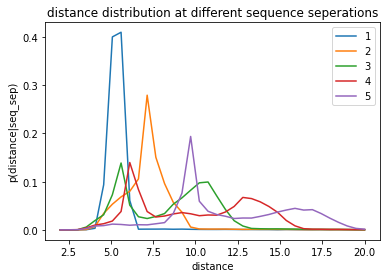

In [19]:
_bkg_dist = split_feat(_bkg)["dist"]
for k in range(1,6):
  plt.plot(np.linspace(2,20,36),
           _bkg_dist[0,k,1:],label=k)
plt.title("distance distribution at different sequence seperations")
plt.xlabel("distance")
plt.ylabel("p(distance|seq_sep)")
plt.legend()
plt.show()

step 2: initialize the design model

In [20]:
%%time
# Note: we trained 5 independent models, during design we backprop through all 5 models
# for thie demo (to save time) we use (n_models=1), for best results use (n_models=5)
model = mk_design_model(add_bkg=True, n_models=1, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['bkg']
CPU times: user 24.9 s, sys: 370 ms, total: 25.2 s
Wall time: 25.2 s


step 3: use model for design (aka. optimize sequence to match background distribution)

In [21]:
design = model.design(inputs={"bkg":_bkg[None]}, opt_iter=200, return_traj=True)

10 loss:{'bkg':-0.38175523}
20 loss:{'bkg':-0.8326315}
30 loss:{'bkg':-1.0294502}
40 loss:{'bkg':-1.1820263}
50 loss:{'bkg':-1.254037}
60 loss:{'bkg':-1.2944645}
70 loss:{'bkg':-1.2825437}
80 loss:{'bkg':-1.2734365}
90 loss:{'bkg':-1.3405873}
100 loss:{'bkg':-1.3459307}
110 loss:{'bkg':-1.3205523}
120 loss:{'bkg':-1.3363466}
130 loss:{'bkg':-1.3721967}
140 loss:{'bkg':-1.370777}
150 loss:{'bkg':-1.3693664}
160 loss:{'bkg':-1.3787893}
170 loss:{'bkg':-1.3812917}
180 loss:{'bkg':-1.3718699}
190 loss:{'bkg':-1.3776497}
200 loss:{'bkg':-1.3596823}
FINAL loss:{'bkg':-1.3803229}


step 4: analyze

In [22]:
# the reported loss it the KL (Kullback–Leibler divergence) between
# the predicted-features and the background-features
# loss = -pred * log(pred/bkg)
-0.25 * (design["feat"] * np.log(design["feat"]/_bkg)).sum(-1).mean()

-1.3803234100341797

predicted features of the designed protein

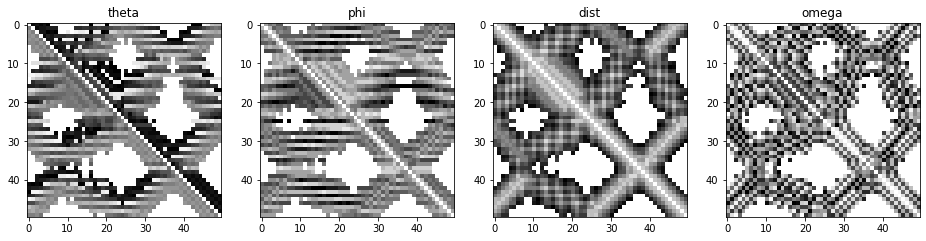

In [23]:
plot_feat(design["feat"])

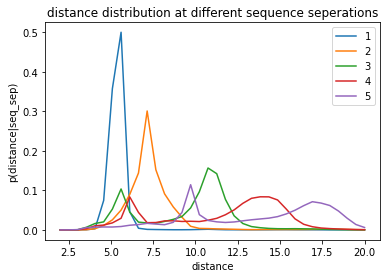

In [24]:
_design_feat_dist = split_feat(design["feat"])["dist"]
_design_L = _design_feat_dist.shape[0]
for k in range(1,6):
  i = np.arange(0,_design_L-k)
  j = np.arange(k,_design_L)
  _tmp = _design_feat_dist[i,j].mean(0)[1:]
  plt.plot(np.linspace(2,20,36),_tmp,label=k)
plt.title("distance distribution at different sequence seperations")
plt.xlabel("distance")
plt.ylabel("p(distance|seq_sep)")
plt.legend()
plt.show()

amino acid sequence of the designed protein

In [25]:
N_to_AA(design["I"].argmax(-1))

['PFTVEMPCDNPDNCEDMIKKLVPPGFTEIKPEMYRVDGGKTWCRMTVKPR']

Animation time!
Here we monitor how the structure (represented as a distance matrix), and sequence (represented as one-hot vector) changes during optimzation. For fun we also show the gradient, that tells the optimizer how to change the sequence to match the desired loss function.

In [26]:
HTML(animate(design))

In [27]:
get_pdb(design,"my_design.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#**PART 4** - Structure Prediction

In [28]:
%%bash
wget -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A8I3.fas

In [29]:
headers, sequences = parse_fasta("P0A8I3.fas")
msa = mk_msa(sequences)[...,:20]

In [30]:
model = mk_design_model(msa_design=True, n_models=5, serial=True, lid=[0,0], uid=[0.8,100.0])

mode: msa design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae


In [31]:
pred = model.predict(inputs={"I":msa[None]})

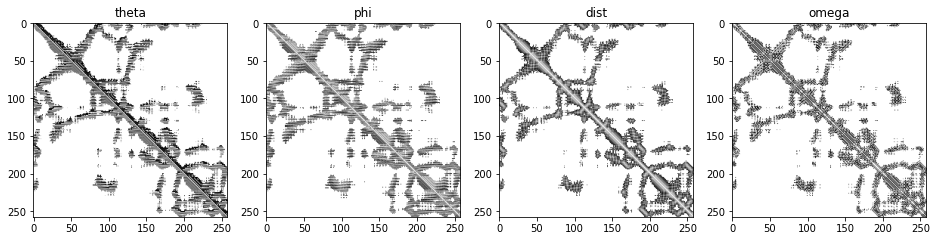

In [32]:
plot_feat(pred["feat"])

In [33]:
get_pdb(pred,"P0A8I3.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol